In [22]:
import pandas as pd
import re
data = pd.read_csv('pesquisausuarios.csv')

df_oportunidade = pd.DataFrame()

for column in data.columns:
    if "Satisfacao" in column:
        m = re.search('Satisfacao (.*)', column)
        new_col = m.group(1)
        df_oportunidade["Oportunidade " + new_col] = data.apply(lambda row: row["Importancia " + new_col] + max(int(row["Importancia " + new_col] - row["Satisfacao " + new_col]),0), axis=1)

df_oportunidade

# Descobre os clusters

In [51]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=2)
data['Cluster'] = cluster.fit_predict(data.iloc[:,2:])

data

# Agrupa por Cluster

In [4]:
df = data.iloc[:,1:].groupby(['Cluster'], as_index = False).mean()
df

,Cluster,Importancia 1,Satisfacao 1,Importancia 2,Satisfacao 2,Importancia 3,Satisfacao 3,Importancia 4,Satisfacao 4,Importancia 5,...,Importancia 17,Satisfacao 17,Importancia 18,Satisfacao 18,Importancia 19,Satisfacao 19,Importancia 20,Satisfacao 20,Importancia 21,Satisfacao 21
0,0,8.460000,2.220000,6.660000,5.320000,6.260000,5.860000,4.420000,5.420000,5.200000,...,6.100000,4.280000,5.300000,6.280000,5.860000,5.960000,5.080000,5.32,5.320000,4.92
1,1,8.363636,2.772727,4.204545,5.204545,5.909091,4.363636,5.227273,6.363636,7.113636,...,5.204545,6.613636,5.727273,4.340909,5.454545,4.909091,5.204545,6.25,5.636364,5.50


# Agrupa outcomes e cluster

In [5]:
# Transforma colunas de Outcome em linhas, agrupando por Outcome e Cluster
outcomes = pd.melt(df, id_vars=[('Cluster')])
outcomes

Importancia = outcomes[outcomes.variable.str.contains("Importancia.*")]
Satisfacao = outcomes[outcomes.variable.str.contains("Satisfacao.*")]


# Descobre Outcomes atrativos

In [6]:
new = {'Outcome': Importancia['variable']}
df_segmento = pd.DataFrame(data=new)
df_segmento['Cluster'] = Importancia['Cluster']
df_segmento['Satisfacao'] = Satisfacao['value'].values #ler https://stackoverflow.com/a/26221919
df_segmento['Importancia'] = Importancia['value']
df_segmento.tail()

,Outcome,Cluster,Satisfacao,Importancia
73,Importancia 19,1,4.909091,5.454545
76,Importancia 20,0,5.320000,5.080000
77,Importancia 20,1,6.250000,5.204545
80,Importancia 21,0,4.920000,5.320000
81,Importancia 21,1,5.500000,5.636364


# Calcular oportunidade e segmento de oportunidade

In [7]:
def calcular_oportunidade_segmento(row):
    row['Oportunidade'] = row['Importancia'] + (row['Importancia'] - row['Satisfacao'])
    if row['Oportunidade'] > 15.0:
        row['Segmento_oportunidade'] =  'Muito atrativo'
    elif row['Oportunidade'] > 10.0 and row['Oportunidade'] < 15.0:
        row['Segmento_oportunidade'] = 'Atrativo'
    else:
        row['Segmento_oportunidade'] = 'Não atrativo'
    return row

df_segmento = df_segmento.apply(calcular_oportunidade_segmento, axis=1)
df_segmento.tail()



,Outcome,Cluster,Satisfacao,Importancia,Oportunidade,Segmento_oportunidade
73,Importancia 19,1,4.909091,5.454545,6.000000,Não atrativo
76,Importancia 20,0,5.320000,5.080000,4.840000,Não atrativo
77,Importancia 20,1,6.250000,5.204545,4.159091,Não atrativo
80,Importancia 21,0,4.920000,5.320000,5.720000,Não atrativo
81,Importancia 21,1,5.500000,5.636364,5.772727,Não atrativo


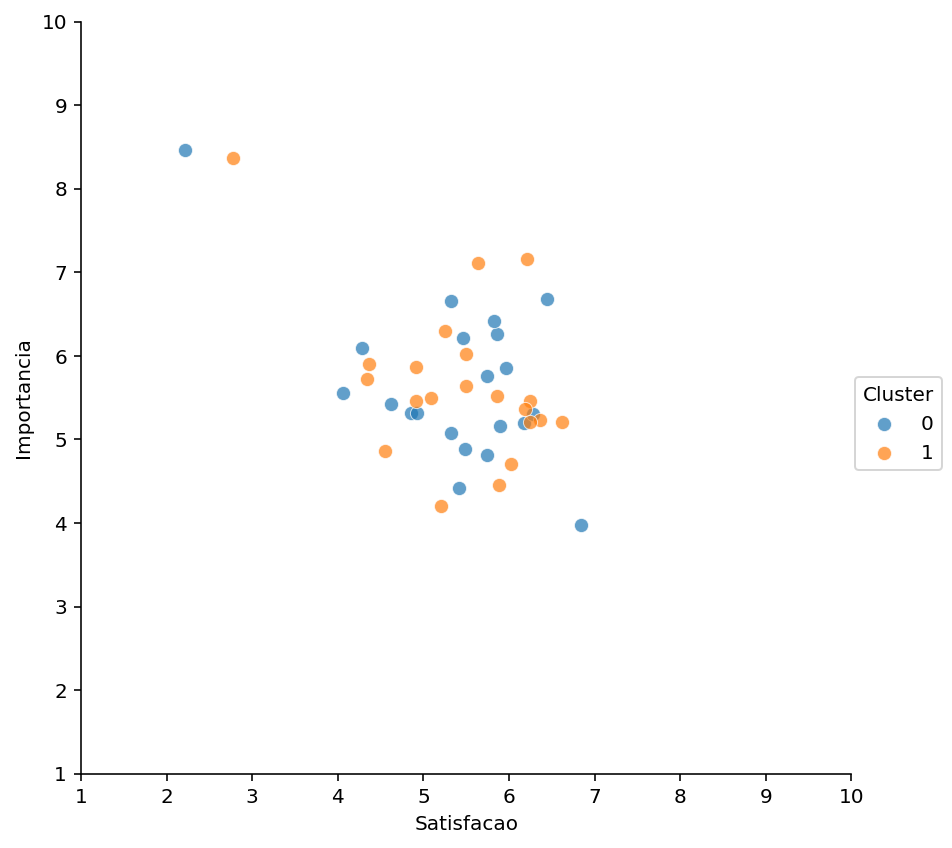

In [29]:
from ggplot import *
import matplotlib.pyplot as plt 
import seaborn as sns

ggplot(df_segmento, aes(x='Satisfacao', y='Importancia', color='Cluster')) + \
    geom_point(size=75) + \
    ggtitle("Customers Grouped by Cluster") + \
    xlim(1, 10) + \
    ylim(1, 10)

g = sns.FacetGrid(df_segmento, hue="Cluster", size=6)
g.map(plt.scatter, "Satisfacao", "Importancia", s=50, alpha=.7, linewidth=.5, edgecolor="white")
g.set(xlim=(1, 10), ylim=(1, 10));
g.add_legend();


In [38]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer()

fa.analyze(df_oportunidade.iloc[:,1:-2], 3, rotation='varimax', method='MINRES')
new_df = fa.loadings

new_df.loc[new_df['Factor1'] < -0.3, 'Factor1'] = -999
new_df.loc[new_df['Factor1'] > 0.3, 'Factor1'] = -999
new_df.loc[new_df['Factor2'] < -0.3, 'Factor2'] = -999
new_df.loc[new_df['Factor2'] > 0.3, 'Factor2'] = -999
new_df.loc[new_df['Factor3'] < -0.3, 'Factor3'] = -999
new_df.loc[new_df['Factor3'] > 0.3, 'Factor3'] = -999

new_df.replace(-999, '')
new_df

ImportError: No module named 'factor_analyzer'

In [4]:
df_oportunidade = data.filter(regex='Oportunidade.*', axis=1)
df_oportunidade
